# Automatic Speech Recognition using CTC

**Authors:** [Mohamed Reda Bouadjenek](https://rbouadjenek.github.io/) and [Ngoc Dung Huynh](https://www.linkedin.com/in/parkerhuynh/)<br>
**Date created:** 2021/09/26<br>
**Last modified:** 2021/09/26<br>
**Description:** Training a CTC-based model for automatic speech recognition.

## Introduction

Speech recognition is an interdisciplinary subfield of computer science
and computational linguistics that develops methodologies and technologies
that enable the recognition and translation of spoken language into text
by computers. It is also known as automatic speech recognition (ASR),
computer speech recognition or speech to text (STT). It incorporates
knowledge and research in the computer science, linguistics and computer
engineering fields.

This demonstration shows how to combine a 2D CNN, RNN and a Connectionist
Temporal Classification (CTC) loss to build an ASR. CTC is an algorithm
used to train deep neural networks in speech recognition, handwriting
recognition and other sequence problems. CTC is used when  we don’t know
how the input aligns with the output (how the characters in the transcript
align to the audio). The model we create is similar to
[DeepSpeech2](https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html).

We will use the LJSpeech dataset from the
[LibriVox](https://librivox.org/) project. It consists of short
audio clips of a single speaker reading passages from 7 non-fiction books.

We will evaluate the quality of the model using
[Word Error Rate (WER)](https://en.wikipedia.org/wiki/Word_error_rate).
WER is obtained by adding up
the substitutions, insertions, and deletions that occur in a sequence of
recognized words. Divide that number by the total number of words originally
spoken. The result is the WER. To get the WER score you need to install the
[jiwer](https://pypi.org/project/jiwer/) package. You can use the following command line:

```
pip install jiwer
```

**References:**

- [LJSpeech Dataset](https://keithito.com/LJ-Speech-Dataset/)
- [Speech recognition](https://en.wikipedia.org/wiki/Speech_recognition)
- [Sequence Modeling With CTC](https://distill.pub/2017/ctc/)
- [DeepSpeech2](https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html)

## Setup

In [54]:
!pip install jiwer
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer


## Load the LJSpeech Dataset

Let's download the [LJSpeech Dataset](https://keithito.com/LJ-Speech-Dataset/).
The dataset contains 13,100 audio files as `wav` files in the `/wavs/` folder.
The label (transcript) for each audio file is a string
given in the `metadata.csv` file. The fields are:

- **ID**: this is the name of the corresponding .wav file
- **Transcription**: words spoken by the reader (UTF-8)
- **Normalized transcription**: transcription with numbers,
ordinals, and monetary units expanded into full words (UTF-8).

For this demo we will use on the "Normalized transcription" field.

Each audio file is a single-channel 16-bit PCM WAV with a sample rate of 22,050 Hz.

In [ ]:
# data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
# data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)

# Aquí define las rutas de archivos para entrenar
wavs_path = "/content/wav/"
metadata_path = "/content/metadata1.csv"

print("agarrando archivo metadata.csv...")

# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(n=523).reset_index(drop=True)

print(f"Se seleccionaron los primeros {len(metadata_df)} archivos de forma ordenada.")
print("Verificando las primeras 5 filas seleccionadas:")
print(metadata_df.head(10))


agarrando archivo metadata.csv...
Se seleccionaron los primeros 523 archivos de forma ordenada.
Verificando las primeras 5 filas seleccionadas:
    file_name                           normalized_transcription
0  LJ002-0010  these numbers had risen to two hundred seventy...
1  LJ002-0259  but the prevailing moral tone may be guessed f...
2  LJ001-0181  When, as is most often the case, there is actu...
3  LJ001-0124  One of the differences between the fine type a...
4  LJ002-0039  they each contained four small rooms or "cabin...
5  LJ001-0170                     being thin, tough, and opaque.
6  LJ002-0187  Every new-comer was entitled to a "chummage" t...
7  LJ002-0002  Under the conditions referred to in the previo...
8  LJ001-0074  the best, mostly French or Low-Country, was ne...
9  LJ002-0055  This arrangement was, however, modified after ...


We now split the data into training and validation set.

In [56]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")


Size of the training set: 470
Size of the training set: 53


## Preprocessing

We first prepare the vocabulary to be used.

In [57]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_(' ')] (size =31)


Next, we create the function that describes the transformation that we apply to each
element of our dataset.

In [58]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label


## Creating `Dataset` objects

We create a `tf.data.Dataset` object that yields
the transformed elements, in the same order as they
appeared in the input.

In [59]:
batch_size = 32
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


## Visualize the data

Let's visualize an example in our dataset, including the
audio clip, the spectrogram and the corresponding label.

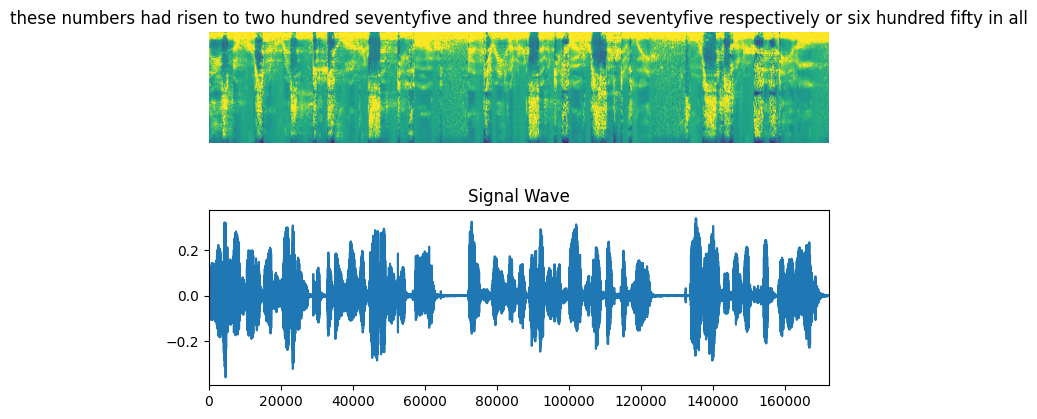

In [60]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

## Model

We first define the CTC Loss function.

In [48]:

def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


We now define our model. We will define a model similar to
[DeepSpeech2](https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html).

In [49]:

def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, None, 193)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ expand_dim (Reshape)                           │ (None, None, 193, 1)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1 (Conv2D)                                │ (None, None, 97, 32)                │              14,432 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_bn (BatchNormalization)                 │ (None, None, 97, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_relu (ReLU)                             │ (None, None, 97, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2 (Conv2D)                                │ (None, None, 49, 32)                │             236,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_bn (BatchNormalization)                 │ (None, None, 49, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_relu (ReLU)                             │ (None, None, 49, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape_3 (Reshape)                            │ (None, None, 1568)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_1 (Bidirectional)                │ (None, None, 1024)                  │           6,395,904 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_15 (Dropout)                           │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_2 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_16 (Dropout)                           │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_3 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_17 (Dropout)                           │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_4 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_18 (Dropout)                           │ (None, None, 1024)                  │                   0 │
├───

 Total params: 26,628,480 (101.58 MB)

 Trainable params: 26,628,352 (101.58 MB)

 Non-trainable params: 128 (512.00 B)

## Training and Evaluating

In [61]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)


Let's start the training process.

In [51]:
# Define the number of epochs.
epochs = 70
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

# --- AÑADE ESTAS LÍNEAS AQUÍ ---
print("Entrenamiento completado. Guardando el modelo...")

# Guarda el modelo completo (arquitectura, pesos y estado del optimizador)
# El formato .keras es el estándar moderno.
model.save("mi_modelo_asr.keras")

print("¡Modelo guardado exitosamente en el archivo 'mi_modelo_asr.keras'!")

Epoch 1/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : but this weekly pittance did not go far when the debtors' side was crowded as it often was
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : the sheriff demanded four shillings six pence for his liberate the jailer six shillings ten pence more and the turnkey two shillings
Prediction: 
----------------------------------------------------------------------------------------------------
15/15 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - loss: 931.2314 - val_loss: 349.4995
Epoch 2/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
-------------------------------------------------

# Mejora la cocina (Continuacion de practica)

In [71]:
# ===================================================================
# CELDA 2: CARGAR O CONSTRUIR MODELO Y CONTINUAR ENTRENAMIENTO
# ===================================================================

import os
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

# --- Requerimientos: Funciones necesarias para el modelo ---
# Es necesario tener estas funciones aquí para que Keras pueda cargar el modelo correctamente.

def CTCLoss(y_true, y_pred):
    # Función de pérdida CTC personalizada.
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    # Función para construir el modelo desde cero (solo se usa la primera vez).
    input_spectrogram = layers.Input((None, input_dim), name="input")
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    x = layers.Conv2D(filters=32, kernel_size=[11, 41], strides=[2, 2], padding="same", use_bias=False, name="conv_1")(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    x = layers.Conv2D(filters=32, kernel_size=[11, 21], strides=[1, 2], padding="same", use_bias=False, name="conv_2")(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(units=rnn_units, activation="tanh", recurrent_activation="sigmoid", use_bias=True, return_sequences=True, reset_after=True, name=f"gru_{i}")
        x = layers.Bidirectional(recurrent, name=f"bidirectional_{i}", merge_mode="concat")(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss=CTCLoss)
    return model

# --- Lógica Principal de Carga o Creación ---

model_file = "mi_modelo_asr.keras" # Nombre del archivo donde guardaremos el progreso

if os.path.exists(model_file):
    print(f"✅ Se encontró un modelo guardado ('{model_file}'). Cargando progreso...")
    model = keras.models.load_model(model_file, custom_objects={"CTCLoss": CTCLoss})
    print("¡Modelo cargado exitosamente! Se continuará el entrenamiento desde este punto.")
else:
    print(f"❌ No se encontró un modelo guardado. Se creará un modelo nuevo desde cero.")
    # Asegúrate de que estas variables estén definidas en la celda anterior
    # fft_length y char_to_num
    model = build_model(
        input_dim=fft_length // 2 + 1,
        output_dim=char_to_num.vocabulary_size(),
        rnn_units=512,
    )
    print("¡Nuevo modelo creado exitosamente!")

print("\nResumen del modelo a entrenar:")
model.summary(line_length=110)


# --- Entrenamiento y Guardado ---

# Define cuántas épocas MÁS quieres entrenar en ESTA sesión
additional_epochs = 20 # Puedes cambiar este número cada vez que ejecutes

# Aquí podrías definir tu callback si lo necesitas
# validation_callback = CallbackEval(validation_dataset)

print(f"\n🚀 Iniciando entrenamiento por {additional_epochs} épocas adicionales...")

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=additional_epochs,
    callbacks=[validation_callback], # Descomenta si usas el callback
)

print("\n✅ ¡Entrenamiento completado!")

# Guardar el modelo con el progreso más reciente
print(f"💾 Guardando el modelo actualizado en '{model_file}'...")
model.save(model_file)
print("¡Modelo guardado exitosamente! El progreso está seguro para la próxima vez.")

✅ Se encontró un modelo guardado ('mi_modelo_asr.keras'). Cargando progreso...
¡Modelo cargado exitosamente! Se continuará el entrenamiento desde este punto.

Resumen del modelo a entrenar:


Model: "DeepSpeech_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, None, 193)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ expand_dim (Reshape)                           │ (None, None, 193, 1)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1 (Conv2D)                                │ (None, None, 97, 32)                │              14,432 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_bn (BatchNormalization)                 │ (None, None, 97, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_relu (ReLU)                             │ (None, None, 97, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2 (Conv2D)                                │ (None, None, 49, 32)                │             236,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_bn (BatchNormalization)                 │ (None, None, 49, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_relu (ReLU)                             │ (None, None, 49, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape_3 (Reshape)                            │ (None, None, 1568)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_1 (Bidirectional)                │ (None, None, 1024)                  │           6,395,904 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_15 (Dropout)                           │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_2 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_16 (Dropout)                           │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_3 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_17 (Dropout)                           │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_4 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_18 (Dropout)                           │ (None, None, 1024)                  │                   0 │
├───

 Total params: 79,885,186 (304.74 MB)

 Trainable params: 26,628,352 (101.58 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 53,256,706 (203.16 MB)


🚀 Iniciando entrenamiento por 20 épocas adicionales...
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1963
----------------------------------------------------------------------------------------------------
Target    : neild found the prisoners in the borough compter ragged starving and dirty
Prediction: neild found the prisoners in the borough compter raged starving and dirty
----------------------------------------------------------------------------------------------------
Target    : hence starvation stared many in the face unless friends from outside came to their assistance
Prediction: hence starvation stared many in the face unles friends from out side came to theire asistance
----------------------------------------------------------------------------------------------------
15/15 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - loss: 2

## Inference

In [72]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.5365
----------------------------------------------------------------------------------------------------
Target    : after his death in the fourteen eighties or at least by fourteen ninety printing in venice had declined very much
Prediction: after whis dalthin the fourteen eights or at least by fourteen ninghty printing invenis hand declined vary mhe
----------------------------------------------------------------------------------------------------
Target    : an elaborate machinery planned for the protection of the trader and altogether on his side had long existed for the recovery of debts
Prediction: an ll laberat mishinory plend for the pritection of the treder and altigevther on his side had lon ay xisted for the recovery of des
-------------------------------------------------------

## Conclusion

In practice, you should train for around 50 epochs or more. Each epoch
takes approximately 5-6mn using a `GeForce RTX 2080 Ti` GPU.
The model we trained at 50 epochs has a `Word Error Rate (WER) ≈ 16% to 17%`.

Some of the transcriptions around epoch 50:

**Audio file: LJ017-0009.wav**
```
- Target    : sir thomas overbury was undoubtedly poisoned by lord rochester in the reign
of james the first
- Prediction: cer thomas overbery was undoubtedly poisoned by lordrochester in the reign
of james the first
```

**Audio file: LJ003-0340.wav**
```
- Target    : the committee does not seem to have yet understood that newgate could be
only and properly replaced
- Prediction: the committee does not seem to have yet understood that newgate could be
only and proberly replace
```

**Audio file: LJ011-0136.wav**
```
- Target    : still no sentence of death was carried out for the offense and in eighteen
thirtytwo
- Prediction: still no sentence of death was carried out for the offense and in eighteen
thirtytwo
```

Example available on HuggingFace.
| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/🤗%20Model-CTC%20ASR-black.svg)](https://huggingface.co/keras-io/ctc_asr) | [![Generic badge](https://img.shields.io/badge/🤗%20Spaces-CTC%20ASR-black.svg)](https://huggingface.co/spaces/keras-io/ctc_asr) |